# Demo - Gaussianization Flow

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(seed=123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [3]:
from rbig_jax.data import NoisySineDataset as PlaneDataset
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_features = 2
noise = 0.1
n_train = 2_000
n_valid = 1_000

ds = PlaneDataset(n_samples=n_train, noise=noise, seed=seed)

data = ds[:]

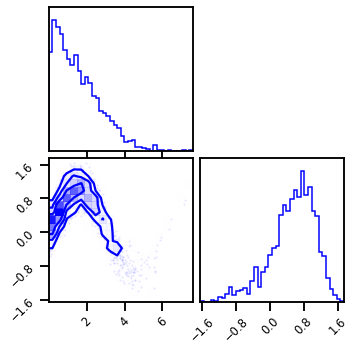

In [4]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

## DataLoader

In [5]:
from rbig_jax.data import GenericDataset, collate_fn
import torch.multiprocessing as multiprocessing
from torch.utils.data import DataLoader

# multiprocessing.set_start_method("spawn")

# initialize dataset
ds_train = PlaneDataset(n_samples=n_train, noise=noise, seed=seed)
ds_valid = PlaneDataset(n_samples=n_valid, noise=noise, seed=seed + 1)

# initialize dataloader
batch_size = 128
shuffle = True

train_dl = DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=shuffle,
    collate_fn=None,
    num_workers=0,
    pin_memory=False,
)
valid_dl = DataLoader(
    ds_valid,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=None,
    num_workers=0,
    pin_memory=False,
)

## Model

In [58]:
from rbig_jax.models.gaussflow import init_default_gf_model

X = jnp.array(ds_train[:], dtype=np.float32)

# marginal uniformization
mixture = "logistic"
n_components = 20
init_mixcdf = "gmm"

# inverse cdf
inverse_cdf = "logistic"

# rotation transformation
n_reflections = 2
init_rotation = "random"

# nn params
n_blocks = 4
plot_layers = False
plot_blocks = False

X_init = np.array(X[:5_000])

In [59]:
# init model
gf_model = init_default_gf_model(
    shape=X.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    mixture=mixture,
    n_components=n_components,
    init_mixcdf=init_mixcdf,
    inverse_cdf=inverse_cdf,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
)

Initializing - Block: 4 | Layer 11: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


### Plot Initial Layers

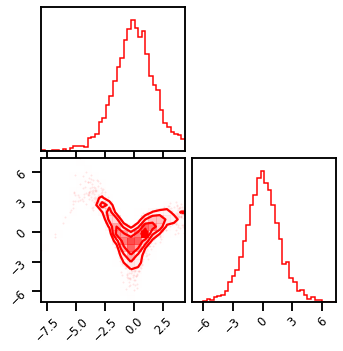

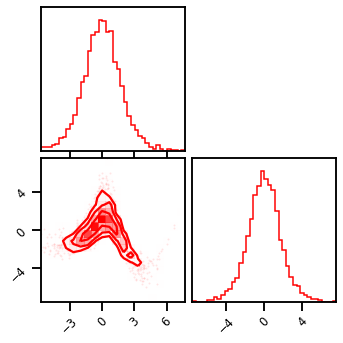

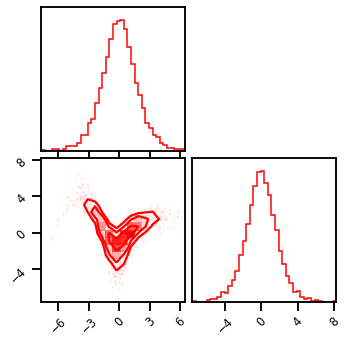

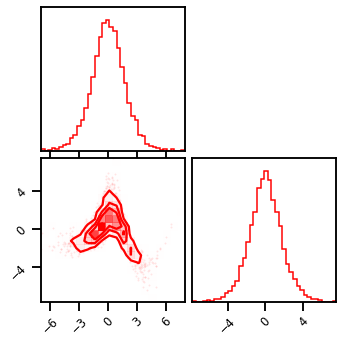

In [60]:
X_g = ds_train[:].copy()

for ibijector in gf_model.bijectors:

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)

In [61]:
gf_model.score(X)

DeviceArray(3.1423185, dtype=float32)

#### Training

In [62]:
final_bijector = gf_model

In [ ]:
from jax.experimental import optimizers
from rbig_jax.training.parametric import init_train_op, init_gf_train_op, train_model


# lr = 0.05
lr = 1e-4
optimizer = optimizers.adam(step_size=lr)
jitted = True
# epochs = 150
epochs = 1_000

# train model
final_bijector, losses = train_model(
    final_bijector,
    train_dl=train_dl,
    valid_dl=valid_dl,
    epochs=epochs,
    optimizer=optimizer,
    jitted=jitted,
)

 38%|███▊      | 376/1000 [23:57<58:19,  5.61s/it, Train Loss=1.4964, Valid Loss=1.5963]  

### Results

#### Losses

In [ ]:
fig, ax = plt.subplots()
ax.plot(losses["train"], label="Training Loss", color="blue")
ax.plot(losses["valid"], label="Validation Loss", color="orange")
ax.set(xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.legend()
plt.tight_layout()
plt.show()

#### Latent Space

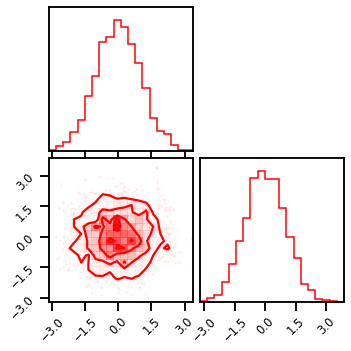

CPU times: user 761 ms, sys: 10.1 ms, total: 771 ms
Wall time: 747 ms


In [47]:
%%time
X_trans = final_bijector.forward(ds_train[:])

fig = corner.corner(np.array(X_trans), color="Red")
plt.show()

#### Inverse Transform

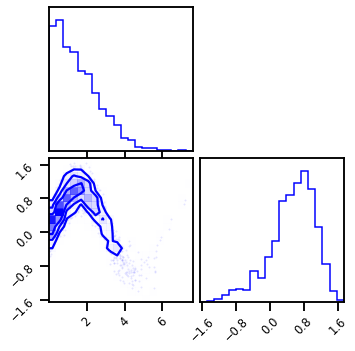

CPU times: user 14 s, sys: 1.24 s, total: 15.2 s
Wall time: 5.99 s


In [48]:
%%time

X_approx = final_bijector.inverse(X_trans)

fig = corner.corner(np.array(X_approx), color="Blue")
plt.show()

### Log Probability

#### Plot: Original Density

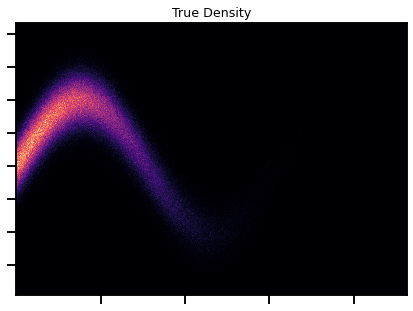

In [49]:
from matplotlib import cm

cmap = cm.magma
# Original Density
n_samples = 1_000_000
ds_plot = PlaneDataset(n_samples=n_samples, noise=noise, seed=seed)
X_plot = ds_plot[:]


fig, ax = plt.subplots(figsize=(7, 5))
h = ax.hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True,  # vmin=0.0, vmax=1.0
)
ax.set_title("True Density")
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.show()

In [50]:
%%time

from rbig_jax.data import generate_2d_grid

# general grid points
xyinput = generate_2d_grid(ds_train[:], 500, buffer=0.2)

# calculate log probability
X_log_prob = final_bijector.score_samples(xyinput)

CPU times: user 3.75 s, sys: 590 ms, total: 4.34 s
Wall time: 2.33 s


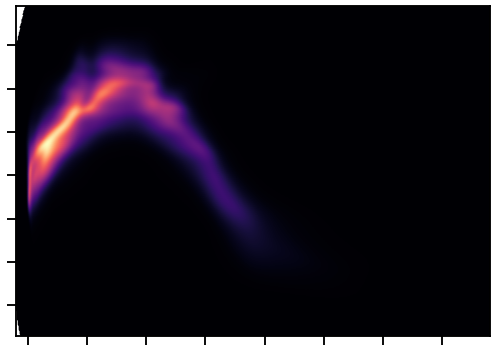

In [51]:
# # Original Density
# n_samples = 1_000_000
# ds_plot = PlaneDataset(n_samples=n_samples, noise=noise, seed=seed)
# X_plot = ds_plot[:]

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(figsize=(7, 5))

h1 = ax.scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap,  # vmin=0.0, vmax=1.0
)
ax.set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)


plt.tight_layout()
plt.show()

### Sampling

In [52]:
# %%time
# n_gen_samples = 100_000
# pred_batch_size = 10_000
# X_samples = []
# for _ in tqdm.trange(n_gen_samples // pred_batch_size):

#     X_samples.append(final_bijector.sample(seed=123, n_samples=pred_batch_size))

In [53]:
%%time

n_gen_samples = 10_000

X_samples = final_bijector.sample(seed=123, n_samples=n_gen_samples)

CPU times: user 29.8 s, sys: 1.15 s, total: 30.9 s
Wall time: 8.98 s


In [21]:
# %%time
# # generate samples in the latent domain
# n_gen_samples = 10_000

# X_g_samples = Normal(0.0, 1.0).sample(seed=123, sample_shape=(n_gen_samples, 2))

# X_samples = final_bijector.inverse(X_g_samples)

# X_samples = np.array(gf_model.inverse(X_g_samples.block_until_ready()))

# # inverse transformation
# f = jax.jit(gf_model.inverse)
# X_samples = np.array(f(X_g_samples))

# # This way works too! But slower
# # generate samples in the latent domain
# n_gen_samples = 10_000

# # # inverse transformation
# X_samples = final_bijector.sample(seed=123, n_samples=n_gen_samples)

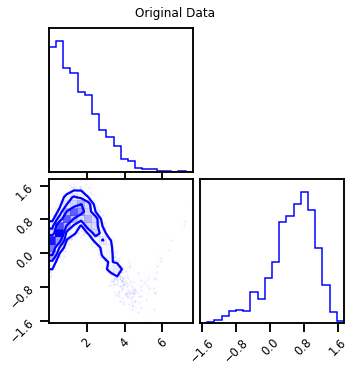

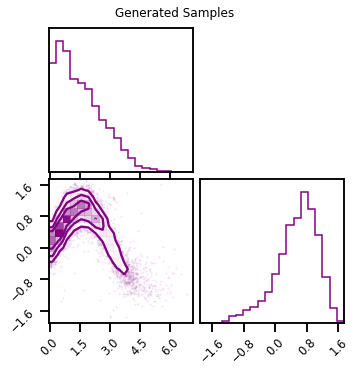

In [54]:
fig = corner.corner(np.array(X), color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(np.array(X_samples), color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Each Layer

#### Original

In [55]:
# X_g = X.copy()

# fig = corner.corner(X_g, color="purple")
# fig.suptitle("Initial")
# plt.show()

# for ilayer, ibijector in enumerate(gf_model.bijectors):

#     X_g = ibijector.forward(X_g)

#     if ibijector.name == "HouseHolder":
#         fig = corner.corner(np.array(X_g), color="purple")
#         fig.suptitle(f"Block: {(ilayer+1)//3}")
#         plt.show()

#### Trained Model

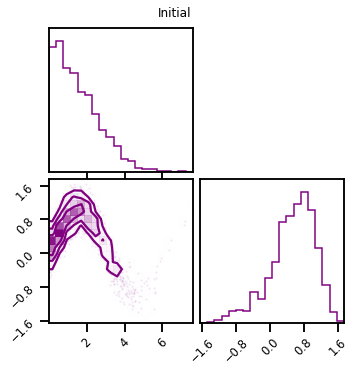

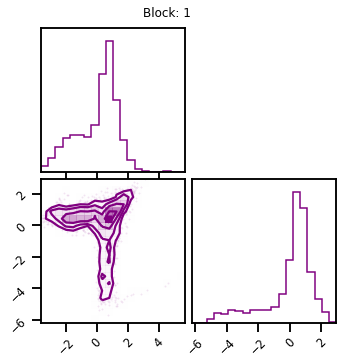

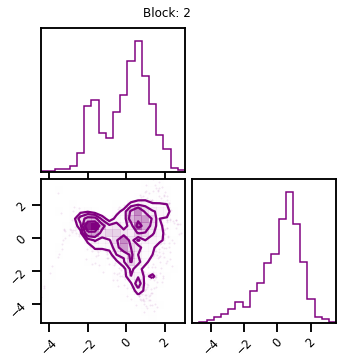

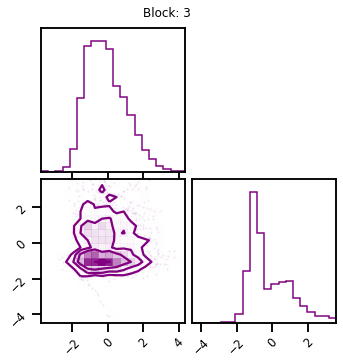

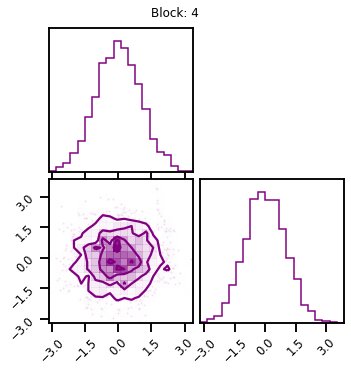

In [56]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")

plt.show()

for ilayer, ibijector in enumerate(final_bijector.bijectors):

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()

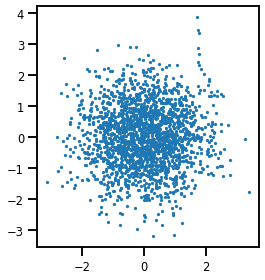

In [57]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect("equal", "box")
plt.tight_layout()

## Saving/Loading Model

In [ ]:
import pickle

#### Save Model

In [ ]:
import joblib

joblib.dump(final_bijector, "gf_model.pickle")

#### Load Model

In [ ]:
rbig_model_loaded = joblib.load("gf_model.pickle")